# Analysis of BALD scores during Training

In [ ]:
# hide
import blackhc.project.script
from nbdev.showdoc import *

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


## Train a simple model


In [ ]:
from typing import Optional

import torch
from ignite.contrib.engines.common import (
    add_early_stopping_by_val_score,
    setup_common_training_handlers,
)
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage
from torch import nn

In [ ]:
from batchbald_redux.acquisition_functions import get_bald_scores, get_batch_bald_batch

In [ ]:
# experiment

import torch.utils.data

from batchbald_redux.consistent_mc_dropout import (
    GeometricMeanPrediction,
    SamplerModel,
    geometric_mean_loss,
    multi_sample_loss,
)
from batchbald_redux.dataset_challenges import create_repeated_MNIST_dataset
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.models import BayesianMNISTCNN

full_train_dataset, test_dataset = create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

model = BayesianMNISTCNN()
train_model = SamplerModel(model, 1)
bald_model = SamplerModel(model, 20)
val_model = GeometricMeanPrediction(SamplerModel(model, 20))

train_dataset = full_train_dataset * (250 / len(full_train_dataset))
print(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

epochs_log = []

LOG_INTERVAL = 10

device = "cuda" if torch.cuda.is_available() else "cpu"

loss = multi_sample_loss(nn.NLLLoss())

# Move model to device before creating the optimizer
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=5e-4)

trainer = create_supervised_trainer(train_model, optimizer, loss, device=device)


def create_metrics(loss):
    return {"accuracy": Accuracy(), "crossentropy": Loss(loss)}


metrics = create_metrics(nn.NLLLoss())

validation_evaluator = create_supervised_evaluator(val_model, metrics=metrics, device=device)


@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    validation_evaluator.run(test_loader)
    print(validation_evaluator.state.metrics)


# Only to look nicer.
RunningAverage(output_transform=lambda x: x).attach(trainer, "crossentropy")

setup_common_training_handlers(trainer, with_gpu_stats=torch.cuda.is_available(), log_every_iters=LOG_INTERVAL)

ProgressBar(persist=False).attach(
    validation_evaluator,
    metric_names="all",
    event_name=Events.ITERATION_COMPLETED(every=LOG_INTERVAL),
)


# Logging
@validation_evaluator.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    metrics = dict(engine.state.metrics)
    epochs_log.append(metrics)


# Kick everything off
trainer.run(train_loader, max_epochs=20)

('FastMNIST (Train)')~x0.004166666666666667


  5%|5         | 1/20 [00:00<?, ?it/s]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.1729, 'crossentropy': 2.2652306640625}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.285, 'crossentropy': 2.1885697265625}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.4012, 'crossentropy': 2.06162734375}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.5649, 'crossentropy': 1.8327623046875}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.6232, 'crossentropy': 1.60885546875}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.7015, 'crossentropy': 1.40335595703125}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.7956, 'crossentropy': 1.20315087890625}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8191, 'crossentropy': 1.0725056640625}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8203, 'crossentropy': 0.99380380859375}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8223, 'crossentropy': 0.94753984375}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8511, 'crossentropy': 0.86159296875}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8586, 'crossentropy': 0.80249765625}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8666, 'crossentropy': 0.75029892578125}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8713, 'crossentropy': 0.730773974609375}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8714, 'crossentropy': 0.739091845703125}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8685, 'crossentropy': 0.72476572265625}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8672, 'crossentropy': 0.692299072265625}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8674, 'crossentropy': 0.684583984375}


[1/157]   1%|           [00:00<?]

{'accuracy': 0.8805, 'crossentropy': 0.6716154296875}


[1/4]  25%|##5        [00:00<?]

[1/157]   1%|           [00:00<?]

{'accuracy': 0.8843, 'crossentropy': 0.67155693359375}


State:
	iteration: 80
	epoch: 20
	epoch_length: 4
	max_epochs: 20
	output: 0.266043096780777
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=64)

In [ ]:
predictions, _ = model.get_predictions_labels(
    loader=full_train_loader, device=device, storage_device="cpu", num_samples=100
)

get_predictions_labels:   0%|          | 0/6000000 [00:00<?, ?it/s]

In [ ]:
import numpy as np

In [ ]:
%%time
batchbald_candidates = get_batch_bald_batch(predictions, batch_size=5, num_samples=1000000, device="cuda")

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 1.74 s, total: 1min 14s
Wall time: 1min 9s


In [ ]:
%%time
batchbald_candidates = get_batch_bald_batch(predictions, batch_size=10, num_samples=1000000, device="cuda")

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/10 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 7.79 GiB total capacity; 3.42 GiB already allocated; 380.50 MiB free; 3.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
batchbald_candidates

CandidateBatch(scores=[0.7621848291043976, 1.4697904100206067, 2.100288493880612, 2.654303620115259, 3.083772302057927], indices=[16909, 18405, 48334, 5129, 30508])

In [ ]:
from batchbald_redux.acquisition_functions.sievebald import * 

In [ ]:
%%time
sievebald_candidates = get_sieve_bald_batch(predictions, batch_size=5, device="cuda")

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 1.27 s, total: 1min 12s
Wall time: 1min 6s


In [ ]:
%%time
sievebald_candidates = get_sieve_bald_batch(predictions, batch_size=10, device="cuda")

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

CPU times: user 2min 18s, sys: 1.52 s, total: 2min 19s
Wall time: 2min 10s


In [ ]:
bald_scores = get_bald_scores(predictions, device="cuda")

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from batchbald_redux import joint_entropy
from batchbald_redux.joint_entropy import *

In [ ]:
@torch.no_grad()
def get_sieve_bald_batch(log_probs_N_K_C: torch.Tensor, *, batch_size: int, dtype=None, device=None) -> CandidateBatch:
    N, K, C = log_probs_N_K_C.shape
    batch_size = min(batch_size, N)

    candidate_scores = []
    candidate_indices = []

    entropies_N = compute_entropy(log_probs_N_K_C)

    # we start with BALD scores
    scores_N = entropies_N - compute_conditional_entropy(log_probs_N_K_C)

    last_score = 0.0
    for _ in range(batch_size):
        # Pick the highest scorer.
        # This is amenable to lazy greedy and lazier than lazy greedy, though we do not implement this here. (Yet)
        candidate_score, candidate_index = scores_N.max(dim=0)

        # TODO: break here if candidate_score < 0 at this point!

        candidate_score += last_score
        last_score = candidate_score

        candidate_indices.append(candidate_index.item())
        candidate_scores.append(candidate_score.item())

        # Update the acquired item's score so it is not picked again.
        scores_N[candidate_index] = -float("inf")

        # Decrease scores for other items
        joint_entropy_helper = joint_entropy.ExactJointEntropy.empty(K, device=device, dtype=dtype)
        joint_entropy_helper.add_variables(log_probs_N_K_C[candidate_index : candidate_index + 1])
        joint_entropies_N = joint_entropy_helper.compute_batch(log_probs_N_K_C)
        dual_mi_N = entropies_N + entropies_N[candidate_index] - joint_entropies_N

        scores_N -= dual_mi_N

    return CandidateBatch(candidate_scores, candidate_indices), scores_N

In [ ]:
sieve_scores = {}
for batch_size in [5, 10, 15, 20, 30]:
    _, sieve_scores[batch_size] = get_sieve_bald_batch(predictions, batch_size=batch_size, device="cuda")

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
torch.save(sieve_scores, "sieve_scores.pt")

In [ ]:
sieve_scores[30][sieve_scores[30] > -float("inf")].max()

tensor(-0.0068, dtype=torch.float64)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
adapted_bald_scores = np.array(bald_scores)
adapted_bald_scores[np.isneginf(sieve_scores[30].numpy())] = -float("inf")

In [ ]:
adapted_bald_scores

array([0.34886887, 0.02939643, 0.1359669 , ..., 0.13787343, 0.13906252,
       0.4097535 ])

In [ ]:
sorted_bald_indices = list(reversed(np.argsort(adapted_bald_scores)))[:-batch_size]

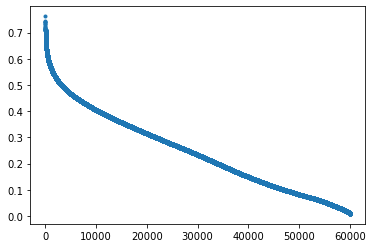

In [ ]:
x, bald_y = zip(*enumerate(adapted_bald_scores[sorted_bald_indices]))
plt.scatter(x, bald_y, marker=".")

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
mpl.rcParams["figure.dpi"] = 150
sns.set_style("whitegrid")

In [ ]:
plt.rcParams.update({
    #"figure.facecolor":  (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.5),  # blue  with alpha = 20%
})

In [ ]:
def savefig(g, path):
    g.savefig(path, transparent=False, dpi=300, bbox_inches="tight", pad_indices=0)

In [ ]:
c = sns.color_palette()
c

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
df = pd.DataFrame.from_dict(
    {
        "BALD": adapted_bald_scores[sorted_bald_indices],
        "2-BALD @5": sieve_scores[5][sorted_bald_indices].numpy(),
        "2-BALD @15": sieve_scores[15][sorted_bald_indices].numpy(),
        "2-BALD @30": sieve_scores[30][sorted_bald_indices].numpy(),
    }
)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df

,index,BALD,2-BALD @5,2-BALD @15,2-BALD @30
0,0,0.762021,0.417033,0.027096,-0.242292
1,1,0.743530,0.363596,-0.025762,-0.290122
2,2,0.741579,0.438415,-0.045048,-0.307338
3,3,0.740570,0.436568,-0.076611,-0.320900
4,4,0.738652,0.314846,-0.064014,-0.341679
...,...,...,...,...,...
59965,59965,0.008777,0.005447,-0.000548,-0.007983
59966,59966,0.008209,0.003554,-0.002918,-0.010072
59967,59967,0.008099,0.005126,-0.000278,-0.007097
59968,59968,0.008011,0.003905,-0.002039,-0.009257


In [ ]:
melted_df = df.melt(id_vars="index")
melted_df

,index,variable,value
0,0,BALD,0.762021
1,1,BALD,0.743530
2,2,BALD,0.741579
3,3,BALD,0.740570
4,4,BALD,0.738652
...,...,...,...
239875,59965,2-BALD @30,-0.007983
239876,59966,2-BALD @30,-0.010072
239877,59967,2-BALD @30,-0.007097
239878,59968,2-BALD @30,-0.009257


In [ ]:
melted_df.variable.unique()

array(['BALD', '2-BALD @5', '2-BALD @15', '2-BALD @30'], dtype=object)

        index    variable     value
161351  41411  2-BALD @15 -0.004326
231706  51796  2-BALD @30 -0.062606
8769     8769        BALD  0.417662
158497  38557  2-BALD @15  0.032457
102576  42606   2-BALD @5  0.084934
...       ...         ...       ...
130025  10085  2-BALD @15  0.070757
227592  47682  2-BALD @30 -0.014276
119748  59778   2-BALD @5  0.009190
82644   22674   2-BALD @5  0.178626
18447   18447        BALD  0.327375

[23988 rows x 3 columns]


/home/blackhc/anaconda3/envs/active_learning/lib/python3.8/site-packages/seaborn/axisgrid.py:65: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_indices" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(*args, **kwargs)


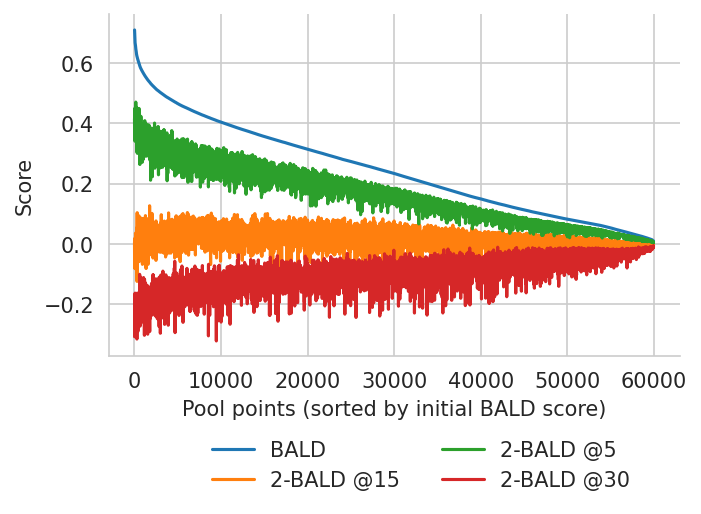

In [ ]:
sub_df = melted_df.sample(frac=0.1).copy()
print(sub_df)
g = sns.relplot(
    data=sub_df,
    x="index",
    y="value",
    hue="variable",
    #palette=sns.color_palette("crest", as_cmap=True),
    hue_order=['BALD', '2-BALD @15', '2-BALD @5', '2-BALD @30'],
    kind="line",
    aspect=1.62,
    height=3,
)
g.set_axis_labels("Pool points (sorted by initial BALD score)", "Score")
g.set_titles("{col_name}")
sns.move_legend(g, "lower left", bbox_to_anchor=(0.25, -0.15), ncol=2, title=None)
savefig(g, "mnist_kbald_score_progression.svg")

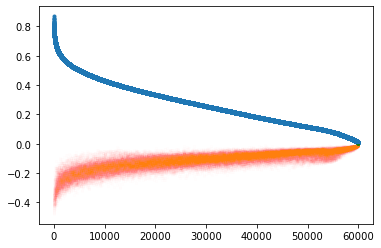

In [ ]:
sieve_scores_y = sieve_scores[sorted_bald_indices].numpy()
plt.scatter(x, bald_y, marker=".")
plt.scatter(x, sieve_scores_y, marker=".", alpha=0.002)

Text(0, 0.5, 'SieveBALD')

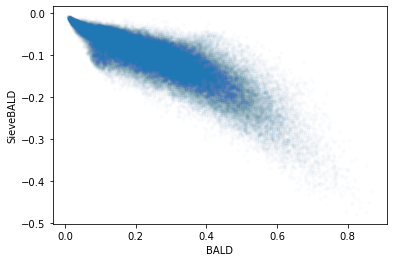

In [ ]:
plt.scatter(bald_y, sieve_scores_y, marker=".", alpha=0.01)
plt.xlabel("BALD")
plt.ylabel("SieveBALD")

In [ ]:
import seaborn as sns

Text(0, 0.5, 'SieveBALD')

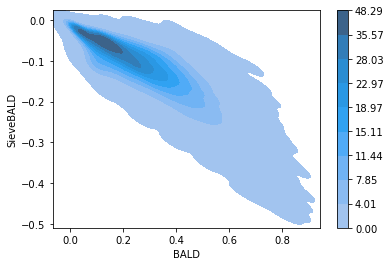

In [ ]:
sns.kdeplot(x=bald_y, y=sieve_scores_y, fill=True, cbar=True, thresh=1 / 60000)
plt.xlabel("BALD")
plt.ylabel("SieveBALD")

In [ ]:
np.diff(batchbald_candidates.scores, prepend=0), bald_scores[batchbald_candidates.indices]

(array([0.79009688, 0.72070044, 0.61477071, 0.52332163, 0.43200564,
        0.34012687]),
 tensor([0.7901, 0.7541, 0.7824, 0.7073, 0.6985, 0.6809], dtype=torch.float64))

In [ ]:
import plotnine as p9

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

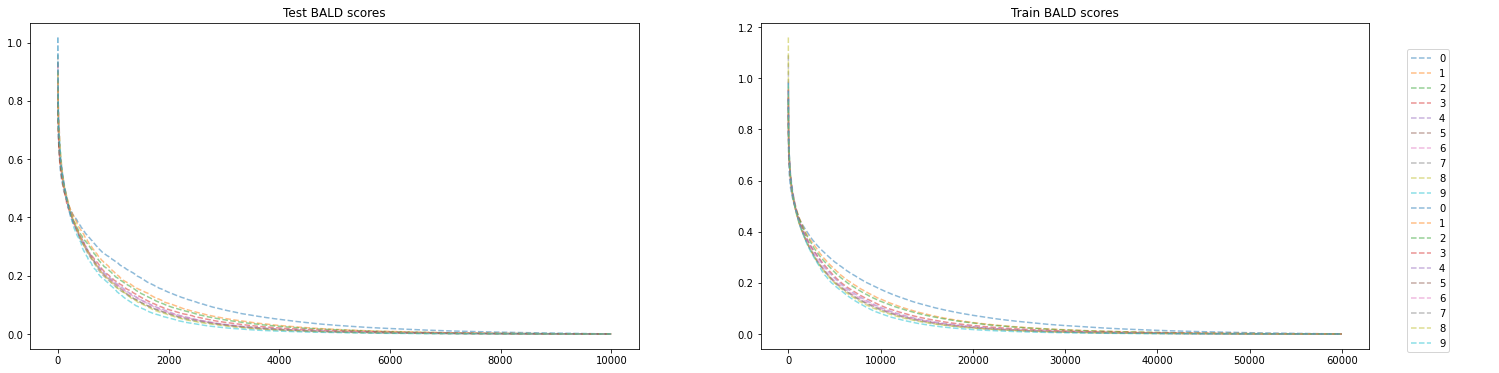

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

for i, test_bald_scores in enumerate(epoch_test_bald_scores):
    sorted_scores = torch.sort(test_bald_scores, descending=True).values
    axes[0].plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

axes[0].set_title("Test BALD scores")

for i, train_bald_scores in enumerate(epoch_train_bald_scores):
    sorted_scores = torch.sort(train_bald_scores, descending=True).values
    axes[1].plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

axes[1].set_title("Train BALD scores")

fig.legend(borderaxespad=5)

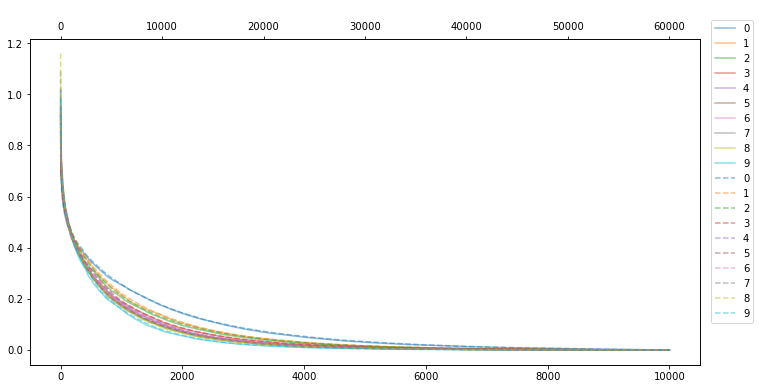

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

for i, test_bald_scores in enumerate(epoch_test_bald_scores):
    sorted_scores = torch.sort(test_bald_scores, descending=True).values
    axes.plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="solid")

axes2 = axes.twiny()

for i, train_bald_scores in enumerate(epoch_train_bald_scores):
    sorted_scores = torch.sort(train_bald_scores, descending=True).values
    axes2.plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

fig.legend(borderaxespad=2)

fig.patch.set_alpha(1)

In [ ]:
%matplotlib widget
plt.interactive(True)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

for i, test_bald_scores in enumerate(epoch_test_bald_scores):
    sorted_scores = torch.sort(test_bald_scores, descending=True).values[:200]
    axes.plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="solid")

axes2 = axes.twiny()

for i, train_bald_scores in enumerate(epoch_train_bald_scores):
    sorted_scores = torch.sort(train_bald_scores, descending=True).values[:1200]
    axes2.plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

fig.legend(borderaxespad=2)

fig.patch.set_alpha(1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

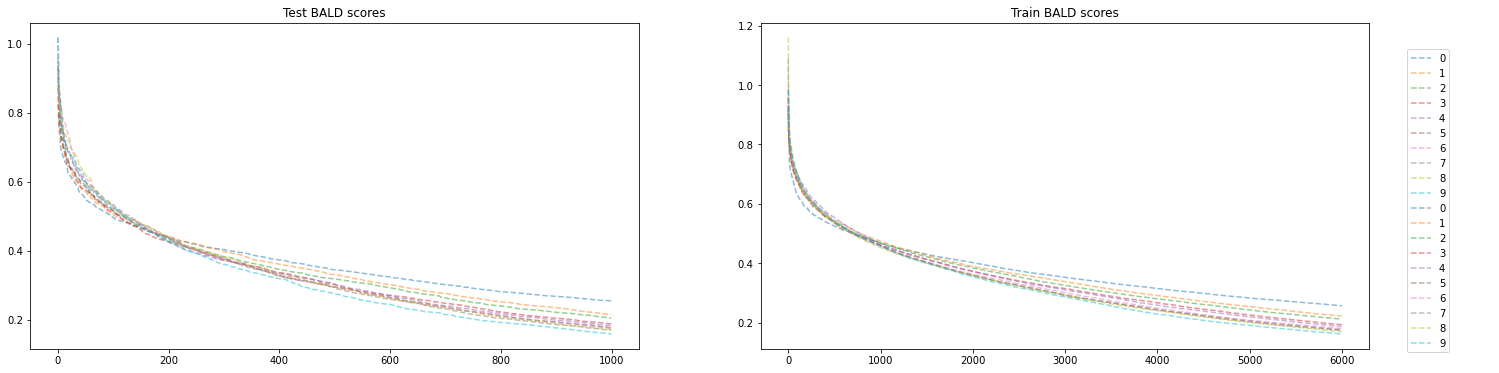

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

for i, test_bald_scores in enumerate(epoch_test_bald_scores):
    sorted_scores = torch.sort(test_bald_scores, descending=True).values[:1000]
    axes[0].plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

axes[0].set_title("Test BALD scores")

for i, train_bald_scores in enumerate(epoch_train_bald_scores):
    sorted_scores = torch.sort(train_bald_scores, descending=True).values[:6000]
    axes[1].plot(np.arange(len(sorted_scores)), sorted_scores.numpy(), label=str(i), alpha=0.5, linestyle="dashed")

axes[1].set_title("Train BALD scores")

fig.legend(borderaxespad=5)

In [ ]:
%config Completer.use_jedi=False

In [ ]:
sorted_scores

torch.return_types.sort(
values=tensor([7.8417e-01, 7.6331e-01, 7.4916e-01,  ..., 5.3502e-06, 4.2994e-06,
        4.2036e-06], dtype=torch.float64),
indices=tensor([2607, 4497, 4571,  ..., 4631, 5659,  981]))